In [1]:
!pip install pyDOE

#you need to add a dataset with GaussJacobiQuadRule_V3 on the right 
import sys
# sys.path.insert(1, '/kaggle/input/quadrule')
from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights

#import GaussJacobiQuadRule_V3


import tensorflow as tf
print(tf.version)
#tf.disable_v2_behavior()
import pyDOE

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pyDOE import lhs
#from GaussJacobiQuadRule_V3.py import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights
import time

2023-09-23 12:57:17.963417: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-23 12:57:17.986184: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-23 12:57:18.188109: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-23 12:57:18.189834: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 12:57:19.083482: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

<module 'tensorflow._api.v2.version' from '/home/mariano/Documenti/test/base/lib/python3.9/site-packages/tensorflow/_api/v2/version/__init__.py'>


In [41]:
x=tf.Variable(1,dtype=tf.float32)
w=tf.Variable(3,dtype=tf.float32)


with tf.GradientTape() as tape:
    tape.watch(w)


    with tf.GradientTape() as tape_:
        tape_.watch(x)
        z=x*x*w*w
    d=tape_.gradient(z,x)
res=tape.gradient(d,w)


print(d)
print(res)

p



RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)

In [66]:
x=tf.Variable(1,dtype=tf.float32)
w=tf.Variable(3,dtype=tf.float32)

with tf.GradientTape() as tape:
    #tape.watch(w)

    for i in range(2):
        with tf.GradientTape() as tape_:
            tape_.watch(x)
            z=call(i)
        d=tape_.gradient(z,x)
res=tape.gradient(d,w)

print(d)
print(res)

2023-09-23 16:31:19.603684: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: Attempting to slice scalar input.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Attempting to slice scalar input. [Op:StridedSlice] name: strided_slice/

In [48]:
var=tf.Variable(initial_value=tf.zeros(shape=(2,10),dtype=tf.float32))
print(var)

<tf.Variable 'Variable:0' shape=(2, 10) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>


In [57]:
def call(i):
    return x[i]*x[i]*w*w

In [2]:
class parameters:
    def __init__(self,N_Element,N_testfcn,N_Quad,lossb_weight,a,b):
        self.var_form=2
        self.N_Element = N_Element
        self.N_testfcn = N_testfcn #number of test function
        self.N_Quad = N_Quad    #quadrature points 
        self.lossb_weight = lossb_weight #hyprparameter we may turn it up

        #params for the exact sol and boundary term
        self.omega = 8*np.pi
        self.amp = 1.0
        self.r1 = 80.0

        #ingredients for loss
        [x,w] = GaussLobattoJacobiWeights(N_Quad, 0, 0)

        self.x_quad= tf.constant(x,dtype=tf.float64)
        self.w_quad= tf.constant(w,dtype=tf.float64)

      
        self.test_quad_element = tf.constant(self.Test_fcn(self.N_testfcn, self.x_quad),dtype=tf.float64)

        d1,d2 = self.dTest_fcn(self.N_testfcn, self.x_quad)


        self.d1test_quad_element=tf.constant(d1,dtype=tf.float64)
        self.d2test_quad_element=tf.constant(d2,dtype=tf.float64)


        [self.x_l, self.x_r] = [a, b] 



        self.delta_x = (self.x_r - self.x_l)/N_Element
        self.grid = tf.constant(np.asarray([ self.x_l + i*self.delta_x for i in range(self.N_Element+1)]),dtype=tf.float64)


        self.F_ext_total = []

        for e in range(self.N_Element):
            x_quad_element = self.grid[e] + (self.grid[e+1]-self.grid[e])/2*(self.x_quad+1)  #traslation of the element 

            jacobian = (self.grid[e+1]-self.grid[e])/2
            testfcn_element = np.asarray([ self.Test_f(n,self.x_quad)  for n in range(1, self.N_testfcn+1)])

            #this is fh calculated on the real nodal values summed over each real nodal values(which comes form CGL nodes )

            f_quad_element = self.f_ext(x_quad_element)
            F_ext_element  = jacobian*np.asarray([sum(self.w_quad*f_quad_element*testfcn_element[i]) for i in range(self.N_testfcn)])    
            F_ext_element = F_ext_element[:,None] 
            self.F_ext_total.append(F_ext_element)

        self.F_ext_total = tf.constant(np.asarray(self.F_ext_total),dtype=tf.float64)

        self.X_bound = tf.constant(np.asarray([a,b])[:,None],dtype=tf.float64)
        self.u_bound   = tf.constant(self.u_exact(self.X_bound),dtype=tf.float64)



    def u_exact(self,x):
        utemp = 0.1*np.sin(self.omega*x) + np.tanh(self.r1*x)
        return self.amp*utemp

    def f_ext(self,x):
        gtemp =  -0.1*(self.omega**2)*np.sin(self.omega*x) - (2*self.r1**2)*(np.tanh(self.r1*x))/((np.cosh(self.r1*x))**2)
        return -self.amp*gtemp

    def Test_f(self,n,x):
        test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
        return test
    
    def Test_fcn(self, N_test,x):
        test_total = []
        for n in range(1,N_test+1):  
            test  = Jacobi(n+1,0,0,x) - Jacobi(n-1,0,0,x)
            test_total.append(test)
        return np.asarray(test_total)

    def dTest_fcn(self, N_test,x):  #valuete the first and second derivatives of test functions on a point x 
        d1test_total = []
        d2test_total = []
        for n in range(1,N_test+1):  
            if n==1:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n==2:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
            else:
                d1test = ((n+2)/2)*Jacobi(n,1,1,x) - ((n)/2)*Jacobi(n-2,1,1,x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1,2,2,x) - ((n)*(n+1)/(2*2))*Jacobi(n-3,2,2,x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)    
        return np.asarray(d1test_total), np.asarray(d2test_total)

In [3]:
params=parameters(5,20,100,1,-1.0,1.0)

/home/mariano/Documenti/test/base/lib/python3.9/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))


In [4]:
tfk=tf.keras
tfkl=tf.keras.layers
input_shape=(1,)
seed=42
input_layer = tfkl.Input(shape=input_shape, name='Input',dtype=tf.float64)
x1 = tfkl.Dense(20, activation=tf.math.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed),dtype=tf.float64)(input_layer)
x2 = tfkl.Dense(20, activation=tf.math.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed),dtype=tf.float64)(x1)
x3 = tfkl.Dense(20, activation=tf.math.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed),dtype=tf.float64)(x2)
x3 = tfkl.Dense(20, activation=tf.math.sin, kernel_initializer = tfk.initializers.GlorotUniform(seed),dtype=tf.float64)(x2)
output_layer = tfkl.Dense(1, activation='linear', kernel_initializer = tfk.initializers.GlorotUniform(seed),dtype=tf.float64)(x3)

In [5]:
model = tf.keras.Model(input_layer, output_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 901 (7.04 KB)
Trainable params: 901 (7.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
def calculate_loss():
 varloss_total = 0
 for e in range(params.N_Element):
    F_ext_element  = params.F_ext_total[e]
    Ntest_element  = np.shape(F_ext_element)[0] #for each element of the grid you have a vector of the focing term (suppose its n-loc),so the you can have at most quad formula n_loc
    
    x_quad_element = params.grid[e] + (params.grid[e+1]-params.grid[e])/2*(params.x_quad+1)
    #to change change integral to the ref segment in (-1,1)
    jacobian= (params.grid[e+1]-params.grid[e])/2

    x_b_element    = np.array([[params.grid[e]], [params.grid[e+1]]])


    test_quad_element =tf.constant(params.Test_fcn(Ntest_element, params.x_quad),dtype=tf.float64)
    d1test_quad_element, d2test_quad_element = tf.constant(params.dTest_fcn(Ntest_element, params.x_quad),dtype=tf.float64)

    d1test_bound_element, d2test_bounda_element = tf.constant(params.dTest_fcn(Ntest_element, np.array([[-1],[1]])),dtype=tf.float64)




    with tf.GradientTape() as tape_:
        tape_.watch(x_quad_element)
        u_NN_quad_element = model(x_quad_element)
    d1u_NN_quad_element=tape_.gradient(u_NN_quad_element,x_quad_element)




    

    if params.var_form == 1:


        with tf.GradientTape() as tape_:
            tape_.watch(x_quad_element)
            u_NN_quad_element = model(x_quad_element)
        d1u_NN_quad_element=tape_.gradient(u_NN_quad_element,x_quad_element)




        with tf.GradientTape() as tape:
            tape.watch(x_quad_element)
        d2u_NN_quad_element=tape.gradient(d1u_NN_quad_element,x_quad_element)    


        U_NN_element = tf.reshape(tf.stack([-jacobian*tf.reduce_sum(params.w_quad*d2u_NN_quad_element*test_quad_element[i]) \
                                        for i in range(Ntest_element)]),(-1,1))
        




        
    if params.var_form == 2:
        with tf.GradientTape() as tape_:
            tape_.watch(x_quad_element)
            u_NN_quad_element = model(x_quad_element)
        d1u_NN_quad_element=tape_.gradient(u_NN_quad_element,x_quad_element)



        U_NN_element = tf.reshape(tf.stack([tf.reduce_sum(params.w_quad*d1u_NN_quad_element*d1test_quad_element[i]) \
                                        for i in range(Ntest_element)]),(-1,1)) 

    if params.var_form == 3:
        u_NN_bound_element = model(x_b_element)
        U_NN_element = tf.reshape(tf.stack([-1/jacobian*tf.reduce_sum(params.wquad*u_NN_quad_element*d2test_quad_element[i]) \
                                            +1/jacobian*tf.reduce_sum(u_NN_bound_element*np.array([-d1test_bound_element[i][0], d1test_bound_element[i][-1]]))  \
                                            for i in range(Ntest_element)]),(-1,1))
        




    Res_NN_element = U_NN_element - F_ext_element
    loss_element = tf.reduce_mean(tf.square(Res_NN_element))
    varloss_total = varloss_total + loss_element





 lossb = tf.reduce_mean(tf.square(model(params.X_bound) - params.u_bound))   #u_NN_pred is what your network has calc,while u_tf is the real value
 return lossb,varloss_total

[-1.         -0.95138033 -0.91502746 -0.90011327 -0.91040062 -0.94329401
 -0.9904944  -1.04009305 -1.07957618 -1.09898214 -1.09341479 -1.06427876
 -1.01892512 -0.96879666 -0.92654083 -0.90281884 -0.90361578 -0.92873058
 -0.97182674 -1.02203105 -1.0666769  -1.09450008 -1.09848078 -1.07761465
 -1.03716625 -0.98734075 -0.94070921 -0.9090368  -0.90031452 -0.91674301
 -0.95417735 -1.00317279 -1.05136774 -1.08660254 -1.09998741 -1.08814534
 -1.05406408 -1.00634239 -0.95702051 -0.9185424  -0.90061615 -0.90776457
 -0.9381841  -0.98419986 -1.03420198 -1.07557399 -1.09785582 -1.09487157
 -1.05344939 -0.69364498  0.69364498  1.05344939  1.09487157  1.09785582
  1.07557399  1.03420198  0.98419986  0.9381841   0.90776457  0.90061615
  0.9185424   0.95702051  1.00634239  1.05406408  1.08814534  1.09998741
  1.08660254  1.05136774  1.00317279  0.95417735  0.91674301  0.90031452
  0.9090368   0.94070921  0.98734075  1.03716625  1.07761465  1.09848078
  1.09450008  1.0666769   1.02203105  0.97182674  0

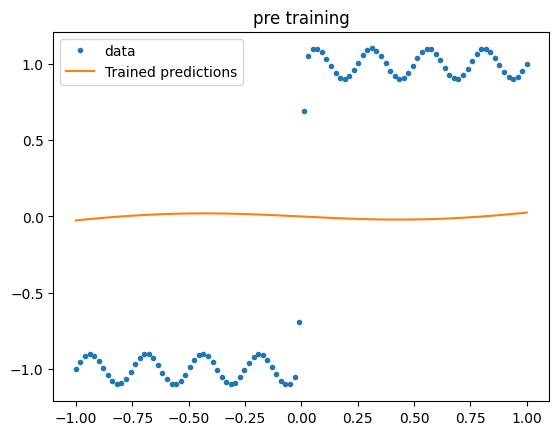

In [7]:
x_test=tf.convert_to_tensor(np.linspace(-1,1,100),tf.float64)
y_test=params.u_exact(x_test)

print((y_test))

plt.plot(x_test,y_test, '.', label="data")
plt.plot(x_test, model(x_test), label='Trained predictions')
plt.title('pre training')
plt.legend();

In [14]:
epochs=1000
total_record=[]
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)



start_time       = time.time()
for epoch in range(epochs+1):
    with tf.GradientTape(persistent=True) as tape:
        
        #tape.watch(model.trainable_variables)
        loss_valueb,loss_valuev=calculate_loss()
        loss=loss_valueb*params.lossb_weight+loss_valuev
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Print training loss for this epoch
    if (epoch) % 100 == 0:
                elapsed = time.time() - start_time
                str_print = 'It: %d, Lossb: %.3e, Lossv: %.3e, Time: %.2f'
                print(str_print % (epoch, loss_valueb, loss_valuev, elapsed))
                start_time = time.time()        
                total_record.append(np.array([epoch, loss,loss_valueb,loss_valuev]))

It: 0, Lossb: 3.639e-02, Lossv: 5.777e+02, Time: 0.29
It: 100, Lossb: 3.119e-01, Lossv: 4.330e+02, Time: 26.44
It: 200, Lossb: 3.443e-02, Lossv: 1.234e+02, Time: 26.50
It: 300, Lossb: 1.400e-03, Lossv: 2.573e+01, Time: 25.92
It: 400, Lossb: 1.564e-04, Lossv: 1.223e+01, Time: 26.50
It: 500, Lossb: 5.561e-03, Lossv: 5.153e+00, Time: 25.88
It: 600, Lossb: 2.005e-03, Lossv: 2.646e+00, Time: 25.89
It: 700, Lossb: 1.534e-04, Lossv: 1.564e+00, Time: 25.87
It: 800, Lossb: 4.123e-04, Lossv: 9.651e-01, Time: 25.73
It: 900, Lossb: 5.835e-04, Lossv: 5.882e-01, Time: 26.15
It: 1000, Lossb: 4.079e-04, Lossv: 3.295e-01, Time: 27.87


<Figure size 640x480 with 0 Axes>

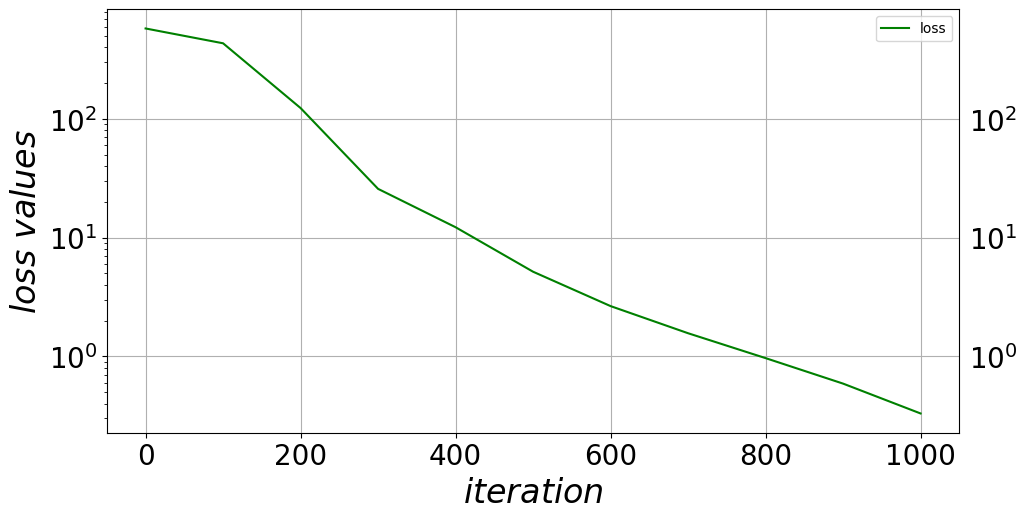

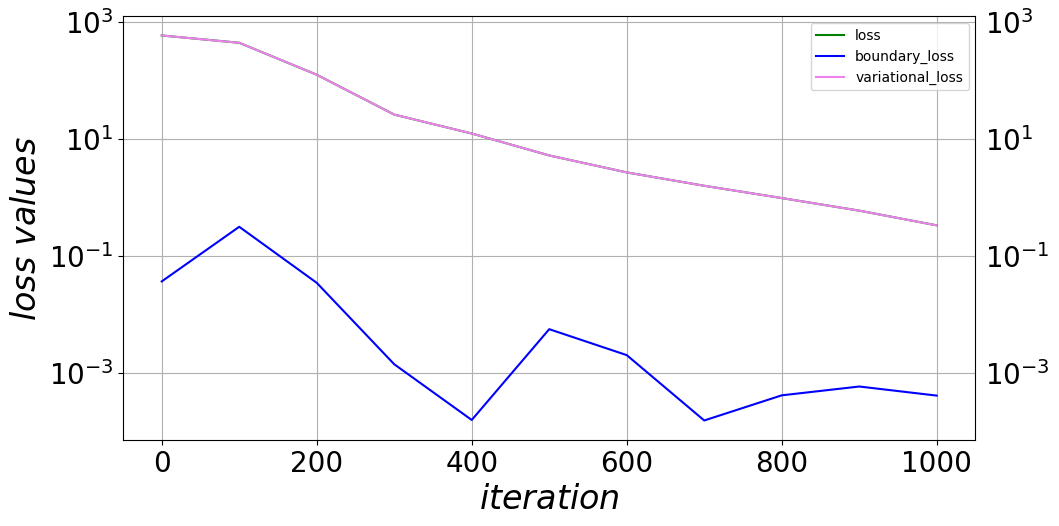

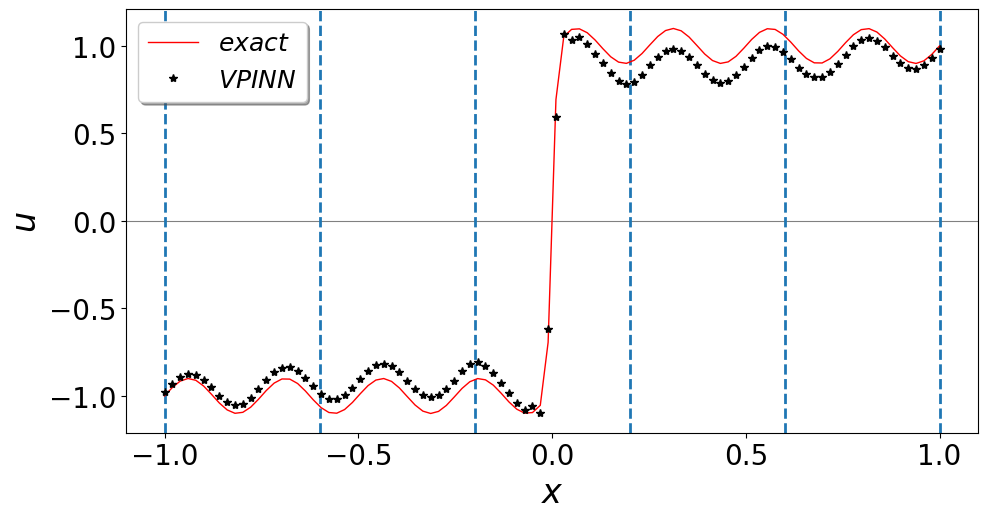

/tmp/ipykernel_21477/2063945903.py:75: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.axvline(x=xc, linewidth=2, ls = '--')


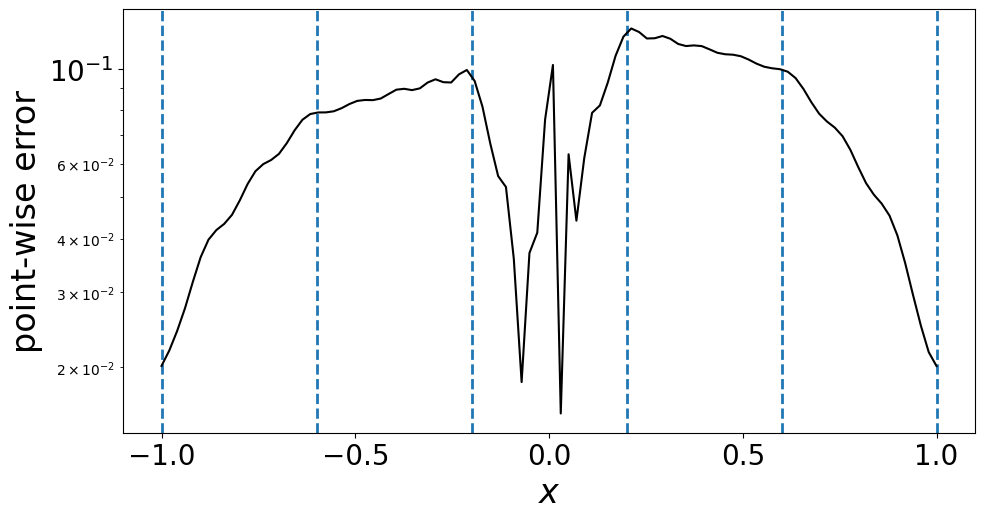

In [15]:
u_pred=model(x_test)
y_test=tf.expand_dims(y_test,axis=1)

fig = plt.figure(0)
gridspec.GridSpec(3,1)


# plt.savefig('Train-Quad-pnts.pdf')    
#++++++++++++++++++++++++++++

font = 24
#all loss
fig, ax = plt.subplots()
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off') 
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss \,\, values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
iteration = [total_record[i][0] for i in range(len(total_record))]
loss_his  = [total_record[i][1] for i in range(len(total_record))]
plt.plot(iteration, loss_his,'green',label="loss")
plt.legend(loc="upper right")
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()
# plt.savefig('loss.pdf')
#++++++++++++++++++++++++++++
#partial loss
fig, ax = plt.subplots()
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss \,\, values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
iteration = [total_record[i][0] for i in range(len(total_record))]
loss_his  = [total_record[i][1] for i in range(len(total_record))]
loss_b  = [total_record[i][2] for i in range(len(total_record))]
loss_v  = [total_record[i][3] for i in range(len(total_record))]
plt.plot(iteration, loss_his,'green',label="loss")
plt.plot(iteration, loss_b,'blue',label="boundary_loss")
plt.plot(iteration, loss_v, 'violet',label="variational_loss")
plt.legend(loc="upper right")
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()


pnt_skip = 25
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=8)

plt.xlabel('$x$', fontsize = font)
plt.ylabel('$u$', fontsize = font)
plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
for xc in params.grid:
    plt.axvline(x=xc, linewidth=2, ls = '--')
plt.plot(x_test, y_test, linewidth=1, color='r', label=''.join(['$exact$']))
plt.plot(x_test, u_pred, 'k*', label='$VPINN$')
plt.tick_params( labelsize = 20)
legend = plt.legend(shadow=True, loc='upper left', fontsize=18, ncol = 1)
fig.set_size_inches(w=11,h=5.5)
plt.show()
# plt.savefig('prediction.pdf')
#++++++++++++++++++++++++++++

fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=8)
plt.xlabel('$x$', fontsize = font)
plt.ylabel('point-wise error', fontsize = font)
plt.yscale('log')
plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
for xc in params.grid:
    plt.axvline(x=xc, linewidth=2, ls = '--')
plt.plot(x_test, tf.abs(y_test - u_pred), 'k')
plt.tick_params( labelsize = 20)
fig.set_size_inches(w=11,h=5.5)
plt.show()

[-1.         -0.95138033 -0.91502746 -0.90011327 -0.91040062 -0.94329401
 -0.9904944  -1.04009305 -1.07957618 -1.09898214 -1.09341479 -1.06427876
 -1.01892512 -0.96879666 -0.92654083 -0.90281884 -0.90361578 -0.92873058
 -0.97182674 -1.02203105 -1.0666769  -1.09450008 -1.09848078 -1.07761465
 -1.03716625 -0.98734075 -0.94070921 -0.9090368  -0.90031452 -0.91674301
 -0.95417735 -1.00317279 -1.05136774 -1.08660254 -1.09998741 -1.08814534
 -1.05406408 -1.00634239 -0.95702051 -0.9185424  -0.90061615 -0.90776457
 -0.9381841  -0.98419986 -1.03420198 -1.07557399 -1.09785582 -1.09487157
 -1.05344939 -0.69364498  0.69364498  1.05344939  1.09487157  1.09785582
  1.07557399  1.03420198  0.98419986  0.9381841   0.90776457  0.90061615
  0.9185424   0.95702051  1.00634239  1.05406408  1.08814534  1.09998741
  1.08660254  1.05136774  1.00317279  0.95417735  0.91674301  0.90031452
  0.9090368   0.94070921  0.98734075  1.03716625  1.07761465  1.09848078
  1.09450008  1.0666769   1.02203105  0.97182674  0

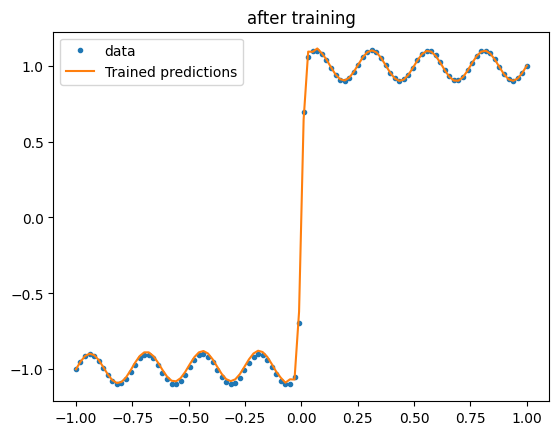

In [ ]:
x_test=tf.convert_to_tensor(np.linspace(-1,1,100),tf.float64)
y_test=params.u_exact(x_test)

print((y_test))

plt.plot(x_test,y_test, '.', label="data")
plt.plot(x_test, model(x_test), label='Trained predictions')
plt.title('after training')
plt.legend();